## Python examples from Sambridge et al. (2022): Demonstrating Derivative calculations

This Jupyter notebook contains python code to illustrate calculations made in 

Sambridge, Jackson & Valentine (2022), [Geophysical Inversion and Optimal Transport](https://doi.org/10.1093/gji/ggac151), *Geophysical Journal International*.

This notebook demonstrates the details of calculations for derivatives of Wasserstein distances with respect to waveform amplitudes. It combines these with derivatives of the waveform amplitudes with respect to their dependent model parameters for the Ricker wavelet example. Comparison with finite differences are made to demonstrate accuracy.

### Import libraries

In [1]:
# read standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize
import time as timer

from libs import FingerprintLib as fp     # Main library for calculating waveform Fingerprint density functions
from libs import OTlib as OT              # Main library for all Optimal Transport calculations 
from libs import ricker_util as ru     # An interface to OT calculation library as well as utility routines

-------

### Optimal Transport and Fingerprint libraries

Most of the derivative details here are general to both the Ricker wavelet and the earthquake source location examples from Sambridge et al. (2022). Figure 6 of the paper shows the various stage of the chain rule required to find derivatives of the Wasserstein misfit with respect to model parameters.

![](images/stages.png)


The main derivatives calculations are in the first tree boxes from the left, while the fourth box applies the time-amplitude transofrm and final box the derivatives of the waveform with respect to its dependent model parameters (the forward problem).
Below we describe the implementation of the first three boxes in this image.

This notebook makes use of an intermediate python script `ricker_util.py`, as well as the two main libraries `FingerprintLib.py` and `OTlib.py`

- `ricker_util.py` contains various utility plot routines, but also acts as an interface to the two libraries: 

- `OTlib.py` containing the author's Optimal Transport calculation library for 1D and marginals of 2D densities fields together with derivatives.

- `FingerprintLib.py` containing routines required to calculate 2D nearest distance fields, their densities from a time series; together with their derivatives with respect to time series amplitudes.

For full details of derivative calculations and their combination via the chain rule see Sambridge et al. (2022). 


-------

### Define Observed wavelet


In [2]:
# define double Ricker wavelet
trange = [-2.,2.] # time window of observed double Ricker wavelet
mtrue = np.array([0.,1.6,1.]) # define true model parameters, toffset, amplitude, f-factor
mstart = np.array([5.0,3.0, 0.5]) # starting guess (high amp)
tpred,wpred = ru.rickerwavelet(mstart[0],mstart[1],mstart[2],trange=trange) # create predicted waveform
tobs,wobs = ru.rickerwavelet(mtrue[0],mtrue[1],mtrue[2],sigma_amp=0.08,sigma_cor=0.03,trange=trange,seed=61254557) # create observed noisy waveform
#tobs,wobs = rickerwavelet(mtrue[0],mtrue[1],mtrue[2],sigma_amp=0.00,sigma_cor=0.03,trange=trange,seed=61254557) # create observed noiseless waveform


Plot the two double ricker wavelets. One, the observed, with correlated noise and the other, the predicted, which is noiseless.

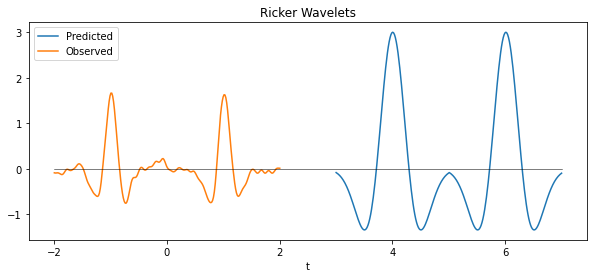

In [3]:
ru.plotrickers(tpred,wpred,tobs,wobs)

#### Setup Time-Amplitude window 

Define a fixed time amplitude window about waveforms. In this example the transformed window in which the 2D density field (Fingerprint) is calculated, is a simple affine transformation in time, amplitude co-ordinates. The transformed window has limits $(0,1)\times(0,1)$.

Note here, that since we define the amplitude of the predicted waveform directly, there is no need to use the arc-tan transform specified in Sambridge et al. (2022).

In [4]:
# choose grid to use
nugrid,ntgrid=80,512 # discretization (amp,time) of fingerprint window
lambdav = 0.03       # distance scale parameter for density field see Sambridge et al. (2022) for explanation
transform = False     # switch to use arc-tan transform of waveform amplitudes
# set up a fixed time-amplitude window about data and predicted waveforms
grid = (trange[0], trange[1], -2.00, 3.5, nugrid,ntgrid) # t0,t1,u0,u1,nu,ny
if(transform): grid = (trange[0], trange[1], -0.8, 1.8, nugrid,ntgrid) # t0,t1,u0,u1,nu,ny (amplitude range can be smaller if using transform)


Build 2D density fields from time series for observed and predicted waveforms and put these in a Fingerprint object.

In [5]:
# set up observed and predicted waveform object
wfobs, wfobs_target = ru.BuildOTobjfromWaveform(tobs,wobs,grid,lambdav=lambdav,transform=transform) # build fingerprint object and OT object for observed waveform
wfpred, wfpred_source = ru.BuildOTobjfromWaveform(tpred,wpred,grid,lambdav=lambdav,deriv=True,transform=transform) # build fingerprint object and OT object for predicted waveform

Plot the waveform nearest distance functions.

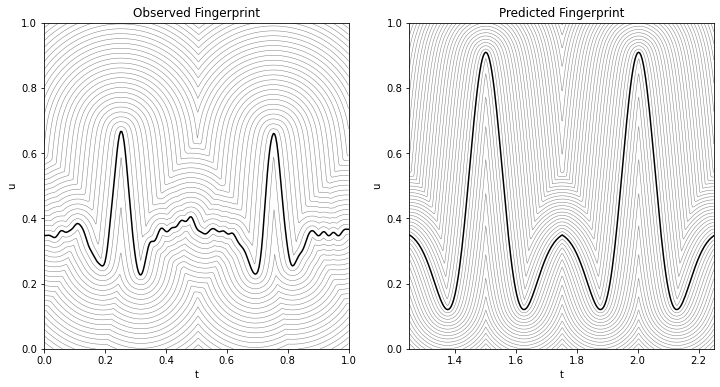

In [6]:
# use fingerprint objects to make plots
ru.fp.plot_2LS(wfobs,wfpred,'Observed Fingerprint','Predicted Fingerprint','black','grey',filename='Figures/Ricker_fingerprints.pdf',fxsize=12,fysize=6) 

This is the fingerprint in the transformed window. In this case we use a simple fixed affine transform over both time and amplitude. As always, the transformed window about the observed waveform has ranges $(0,1)\times(0,1)$. Here the reference plot on the right has higher amplitude than the noisy waveform on the left.

#### 2D waveform nearest distance field, density field and marginals


In a cell above, the routine `BuildOTobjfromWaveform()` was used to create a fingerprint objects for both observed and predicted waveforms. Two class objects are returned. The first is produced by the Fingerprint library `FingerprintLib.py` and the second by the  Optimal Transport library `OTlib.py`.

##### Waveform fingerprint class object
The first output `wfpred` is the waveform fingerprint object produced by the Fingerprint library, e.g. `wfpred=fp.waveformFP()`. This stores all information for specifying waveforms, their time-amplitude windows, nearest distance functions, and density fields.  

This class has a method `wfpred.calcpdf()` which calculates the 2D nearest  field of the time series and puts it into instance `wfpred.dfield`, and also the corresponding density field and puts it in `wfpred.pdf`. 

##### Optimal transport class object
The second output `wfpred_source` is the Optimal Transport class object for a 1D or 2D probablity density function (PDF) produced by the library `OTlib.py` using `wfpred_source=OT.OTpdf()`. This contains the marginals of the 2D density fields plotted in blue below as well as other information required to perfrom Wasserstein distance calcaultions.  The 1D density field marginals may be accessed from:

`wfpred_source.marg[0].pdf` - Height values of time marginal for predicted (source) density field. [This is $p_{pred}^{(t)}$ in section 3.4 of the paper]

`wfpred_source.marg[0].x. ` - Time values of time marginal for predicted (source) density field.

`wfpred_source.marg[1].pdf` - Height of amplitude marginal for predicted (source) density field [This is $p_{pred}^{(u)}$ in section 3.4 of the paper]

`wfpred_source.marg[1].x`   - Time values of amplitude marginal for predicted (source) density field.

Marginals for the observed waveform are in `wfobs_target.marg`.

Below we plot the predicted and observed marginals calculated for the waveforms above.

Here are the marginals and density field for the predicted waveforms.
The first is the amplitude marginal and the second is the time marginal.


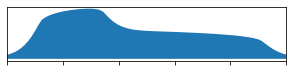

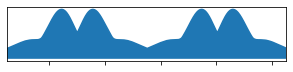

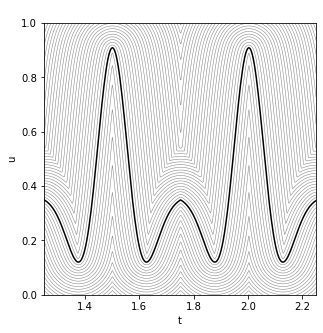

In [7]:
print('Here are the marginals and density field for the predicted waveforms.\n'+
      'The first is the amplitude marginal and the second is the time marginal.')
ru.plotMarginals(wfpred,wfpred_source,tag='_pred',fxsize=5,fysize=5)

Here are the marginals and density field for the observed waveforms.
The first is the amplitude marginal and the second is the time marginal.


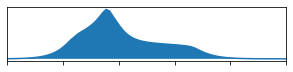

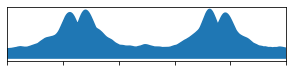

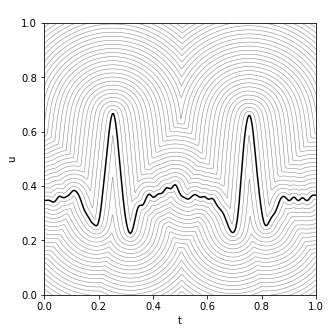

In [8]:
print('Here are the marginals and density field for the observed waveforms.\n'+
      'The first is the amplitude marginal and the second is the time marginal.')

ru.plotMarginals(wfobs, wfobs_target,tag='_obs',fxsize=5,fysize=5)

In [9]:
print(' Here is the 2D distance field of the predicted waveform with shape',np.shape(wfpred.dfield),'\n',
      'and values:\n', wfpred.dfield)

 Here is the 2D distance field of the predicted waveform with shape (80, 512) 
 and values:
 [[0.17128621 0.16994805 0.16862197 ... 0.16600218 0.16730315 0.1686168 ]
 [0.16231917 0.16090645 0.15950522 ... 0.15673312 0.15811038 0.15949975]
 [0.15387177 0.15238075 0.15090038 ... 0.14796715 0.14942523 0.1508946 ]
 ...
 [0.25444218 0.25258444 0.2507267  ... 0.24700394 0.24886168 0.25071942]
 [0.2585147  0.25667503 0.25483709 ... 0.25115943 0.25299375 0.25482989]
 [0.26308483 0.26127734 0.25947201 ... 0.25586098 0.25766182 0.25946493]]


In [10]:
print(' Here is the 2D density field of the predicted waveform with shape',np.shape(wfpred.pdf),'\n',
      'and values:\n', wfpred.pdf)

 Here is the 2D density field of the predicted waveform with shape (80, 512) 
 and values:
 [[0.01381286 0.01428277 0.01476421 ... 0.01576356 0.01525911 0.01476612]
 [0.01728391 0.01790525 0.0185436  ... 0.0198743  0.01920164 0.01854614]
 [0.02134806 0.02215884 0.02299429 ... 0.02474384 0.02385812 0.02299761]
 ...
 [0.00172754 0.00180967 0.0018957  ... 0.0020806  0.00198618 0.00189604]
 [0.00156031 0.00163375 0.00171057 ... 0.0018753  0.00179125 0.00171088]
 [0.00139185 0.00145619 0.00152342 ... 0.00166734 0.00159394 0.00152369]]


#### Raypaths for nearest distance field 

Each point in the nearest distance field (contoured above) corresponds to a single, nearest location, on the waveform. Rays, which are perpendicular to wavefronts, can be drawn between each position in the time-amplitude window and nearest point on the ray. Below is an example. 

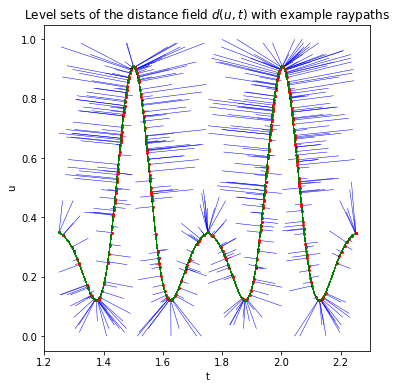

In [11]:
fp.plot_rays(np.random.randint(0, nugrid*ntgrid,500),wfpred,
             'Level sets of the distance field $d(u,t)$ with example raypaths','cyan','grey',fxsize=6,fysize=6)

#### Derivatives of distance field with respect to waveform amplitudes

Here the waveform is discretized and represented as a series of piecewise linear segments. This means that for each point in the grid, the derivative of the density field with respect to the amplitude of the waveform is only non-zero for the two end points of the corresponding linear segment along the waveform.

The class function `wfpred.calcpdf()` calculates the nearest distance field and the density field for the waveform.

- `wfpred.dfield` : ndarray; shape(Ntg,Nug); nearest distance field from waveform, $d_{ij}$. See eqn. (C.5) in Appendix C of paper.

- `wfpred.pdf` : ndarray; shape(Ntg,Nug); density field $p_{ij} = \exp(-d_{ij}/s)$. [$s=$ `lambdav`]

With `deriv=True` it also returns the derivative of the distance field with respect to the waveform amplitudes. Several arrays are calculated which are required for subsequent interpretation of these derivatives:

- `wfpred.dddy`   : ndarray; shape(NtgxNug,2); derivatives of nearest distance field from waveform, $\partial d_{ij}/\partial u_k$, $\partial d_{ij}/\partial u_{k+1}$ where $u_k$ and $u_{k+1}$ are the amplitudes of the end points of the nearest segment along the waveform. See eqns. (C.9) and (C.10) in Appendix C of paper.

- `wfpred.irays` : integer array; shape(NtgxNug); index of waveform linear segment closest to each grid point $(0,nt-2)$. See Appendix C of paper.
- `wfpred.lrays` : ndarray; shape(NtgxNug); relative position along segment of closest point. This is $\lambda^*$ in Appendix C of paper.
- `wfpred.xrays` : ndarray; shape(NtgxNug,2); point along waveform closest to each grid point. This is ${\bf x}(\lambda^*)$ in Appendix C of paper.




##### Comparison with finite differences

Here we compare the analytically calculated derivatives above with finite difference estimates. This can be an expensive calculation so we restrict the calculation to a random subset of grid points in the $ntg\times nug$ time-amplitude window. 

Note that because finite differences require a perturbation to the wavform amplitude, it is possible in some cases that the estimates of derivatives can have larger errors, either because i) the perturbation of the amplityde is too large, or ii) if an amplitude perturbation to the waveform causes a change in the nearest waveform segment association. These errors do not affect teh analytical derivatives which reman acccurate, but in these circumstances discrpeancies between the two derivative estimates will occur. 

In [12]:
# compare derivatives of with finite difference
Nfd = 30 # Number of random grod points to compare derivatives with finite difference (0,Nt*Nu)
gridpoints = np.random.choice(wfpred.dfield.size, Nfd) # random selection of grid points to calculate derivatives
print('Comparing analytical results to finite difference derivatives\n\n',
      'Grid point  ray segment   FD Derivatives     Analytical\n',
      '                         dd/du0   dd/du1   dd/du0   dd/du1')

for k in gridpoints:  # compare derivatives to finite difference. This will take ~39s x 2 x NtxNu
    i,dddy0fd,dddy1fd = fp.check_FDderiv(wfpred,k,du=0.001)
    print(" %7d %11d     %+7.5f %+7.5f %+7.5f %+7.5f" %(k,i,dddy0fd,dddy1fd,wfpred.dddy[k][0],wfpred.dddy[k][1]))


Comparing analytical results to finite difference derivatives

 Grid point  ray segment   FD Derivatives     Analytical
                          dd/du0   dd/du1   dd/du0   dd/du1
   30021         182     -0.00373 -0.01571 -0.00373 -0.01571
   18246         175     -0.00846 -0.00973 -0.00846 -0.00973
    8361          87     +0.00472 +0.02582 +0.00472 +0.02581
   19979           0     -0.17984 +0.00000 -0.17984 +0.00000
   35573          69     -0.01651 -0.01218 -0.01652 -0.01216
    1343         159     +0.00000 +0.18172 +0.00000 +0.18172
   14281         211     -0.01499 -0.00607 -0.01499 -0.00607
   30669         200     -0.00077 -0.01997 -0.00077 -0.01997
   24243          76     -0.00544 -0.01210 -0.00544 -0.01210
    7299          88     +0.02355 +0.01132 +0.02355 +0.01132
    9094         214     +0.00303 +0.02419 +0.00303 +0.02418
   32999          71     -0.01576 -0.00679 -0.01576 -0.00678
   12149         171     +0.00860 +0.01403 +0.00860 +0.01403
   10887          85     +0

#### Marginal Wasserstein distances and their derivatives with respect to denisty grid amplitudes

Here we demonstrate the calculation of the two Marginal Wasserstein distances, $W_2^2(p_{obs}^{(t)},p_{pre}^{(t)}),W_2^2(p_{obs}^{(u)},p_{pre}^{(u)})$, and their derivatives with respect to the 2D Fingerprint densities.

In [13]:
# Calculate Marginal Wasserstein distances and derivatives
w, dwdpbar, dwdt0  = OT.MargWasserstein(wfpred_source,wfobs_target,derivatives=True,distfunc='W2',returnmargW=True) # calculate Wasserstein and derivatives


The Marginal Wasserstein routine returns the Wasserstein distances between time/amplitude marginals, optionally with derivatives:

`w` - list of floats, shape (2); Wasserstein distances between (time,amplitude) marginals. [ $W_2^2(p_{obs}^{(t)},p_{pre}^{(t)}),W_2^2(p_{obs}^{(u)},p_{pre}^{(u)})$ in section 3.4 of paper]

with `derivatives=True` it also returns two sets of derivatives:

`dwdpbar` - list of 2 ndarrays, each with shape (Nt,Nu); Derivatives of Wasserstein distances between (time,amplitude) marginals with respect to the density field. [$\partial W_2^2(p_{obs}^{(t)},p_{pre}^{(t)})/\partial \bar p_{ij} $
and $\partial W_2^2(p_{obs}^{(u)},p_{pre}^{(u)})/\partial \bar p_{ij} $, abbreviated to $\partial W_t/\partial \bar p_{ij} $ 
and $\partial W_u/\partial \bar p_{ij} $ in Appendix D of the paper.]

`dwdt0` - list of floats, shape (2); Derivatives of Wasserstein distances between (time,amplitude) marginals with respect to the origin of the time window. [$\partial W_2^2(p_{obs}^{(t)},p_{pre}^{(t)})/\partial t_0 $ and $\partial W_2^2(p_{obs}^{(u)},p_{pre}^{(u)})/\partial t_0 $.] 

Note that in many inverse problems it is common to include the onset time of the predicted time-series/waveform as an unknown to be solved for. Hence the derivative of each Marginal Wasserstein misfit with respect to origin time will be required. Since this can be calculated directly by the OT library and so is also returned by the routine `OT.MargWasserstein` as the third output when `deriv=True`.


##### Comparison with finite differences

Here we compare the analytically calculated derivatives above with finite difference estimates. This can be an expensive calculation so we restrict the caluclation to a random subset of grid points in the $ntg\times nug$ time-amplitude window.

In [14]:
# check derivative from MargWasserstein with finite differences
df = 0.5 # percentage perturbation of maximum waveform density 
Nfd = 30 # Number of random grod points to compare derivatives with finite difference (0,Nt*Nu)
gridpoints = np.random.choice(wfpred.dfield.size, Nfd) # random selection of grid points to calculate derivatives
print('Comparing analytical results to finite difference derivatives:\n',
      'Grid point          FD Derivatives            Analytical values \n',
      '                dWt/dpbar     dWu/dpbar     dWt/dpbar    dWu/dpbar')

for k in gridpoints:  # compare derivatives to finite difference. This will take ~39s x 2 x NtxNu
    wfd0,wfd1 = OT._checkderivMarg(wfpred_source,wfobs_target,df,distfunc='W2',percent=True,ind=[k],returnmargW=True)
    print(" %7d      %+12.10f %+12.10f %+12.10f %+12.10f" %(k,wfd0,wfd1,dwdpbar[0].flatten()[k],dwdpbar[1].flatten()[k]))


Comparing analytical results to finite difference derivatives:
 Grid point          FD Derivatives            Analytical values 
                 dWt/dpbar     dWu/dpbar     dWt/dpbar    dWu/dpbar
    6302      -0.0000409379 -0.0000008953 -0.0000409379 -0.0000008953
   11236      +0.0000948034 -0.0000023993 +0.0000948034 -0.0000023993
   14513      -0.0000330036 -0.0000029278 -0.0000330036 -0.0000029278
   12749      +0.0000852427 -0.0000027110 +0.0000852427 -0.0000027110
   30191      +0.0000993470 +0.0000032781 +0.0000993470 +0.0000032781
   22195      -0.0000321704 -0.0000012882 -0.0000321704 -0.0000012882
   30157      +0.0000852427 +0.0000032781 +0.0000852427 +0.0000032781
   34237      +0.0000785681 +0.0000064759 +0.0000785681 +0.0000064759
   25977      +0.0000501633 +0.0000005952 +0.0000501633 +0.0000005952
   23319      +0.0000095482 -0.0000008004 +0.0000095482 -0.0000008004
    7657      +0.0000968705 -0.0000013018 +0.0000968705 -0.0000013018
   33064      +0.0000166855 +0.00

#### Derivatives of Marginal Wasserstein misfits with respect to waveform amplitudes

We now combine the derivatives calculated above using the chain rule to get the derivatives of the Marginal Wasserstein misfits with respect to the original waveform amplitudes, $$\partial W_2^2(p_{obs}^{(t)},p_{pre}^{(t)})/\partial u_k, \quad  \partial W_2^2(p_{obs}^{(u)},p_{pre}^{(u)})/\partial u_k \quad (k=1,\dots,N_t)$$

The resulting derivatives are placed in `wfpred.pdfdMarg[0]` for the time marginal and `wfpred.pdfdMarg[1]` for the amplitude marginal.

In the next cell we calculate these derivatives and  use the chain rule to correct derivatives if the arctan amplitude transform has been used.

In [15]:
# use OT class method to combine derivatives using the chain rule
wfpred.PDFderivMarg(dwdpbar)  # get derivative of W marginals wrt to unormalized waveform amplitudes
if(transform): # if we have arctan transform on amplitudes then we need to correct derivatives for this transform
    un,dundu = ru.arctan_trans(wpred,grid[2],grid[3],deriv=True)
    wfpred.pdfdMarg[0] = wfpred.pdfdMarg[0]*dundu # correct time-marginal Wasserstein misfit for amplitude transform
    wfpred.pdfdMarg[1] = wfpred.pdfdMarg[1]*dundu # correct amplitude-marginal Wasserstein misfit for amplitude transform


In [16]:
# write out derivatives
print(' Here are the derivatives of the Wasserstein misfit between time marginals with shape',np.shape(wfpred.pdfdMarg[0]),'\n',
      'and values:\n', wfpred.pdfdMarg[0][:20],'...\n')
print(' Here are the derivatives of the Wasserstein misfit between amplitude marginals with shape',np.shape(wfpred.pdfdMarg[1]),'\n',
      'and values:\n', wfpred.pdfdMarg[1][:20],'...\n')
print(' Here are the derivatives of the Wasserstein misfit between time/amplitude marginals with respect to the time window origin\n',
      dwdt0[0]/(wfpred.tlim[1]-wfpred.tlim[0]),dwdt0[1]/(wfpred.tlim[1]-wfpred.tlim[0]))

 Here are the derivatives of the Wasserstein misfit between time marginals with shape (256,) 
 and values:
 [-0.01617752 -0.00300502 -0.00222339 -0.00282386 -0.00267624 -0.00144765
 -0.00135808 -0.00169161 -0.00079482 -0.00144394 -0.00045872 -0.00089458
 -0.00011091 -0.00014803 -0.00019455  0.00028506  0.00027012  0.00034231
  0.00047574  0.00051796] ...

 Here are the derivatives of the Wasserstein misfit between amplitude marginals with shape (256,) 
 and values:
 [-4.37814996e-04 -8.78206530e-05 -6.74365007e-05 -8.53915700e-05
 -8.20707705e-05 -4.85155306e-05 -4.59501588e-05 -5.60389151e-05
 -3.06069890e-05 -4.91391215e-05 -2.12696557e-05 -3.36466307e-05
 -1.15682424e-05 -1.30601689e-05 -1.41773144e-05 -1.53548662e-06
 -2.25122232e-06 -1.12727001e-06  1.84450392e-06  2.44572702e-06] ...

 Here are the derivatives of the Wasserstein misfit between time/amplitude marginals with respect to the time window origin
 0.6263231659609353 0.0


##### Comparison with finite differences

Here we compare the analytically calculated derivatives above with finite difference estimates.

In [17]:
# check derivative from MargWasserstein with finite differences
df = 0.1 # percentage perturbation of maximum waveform density 
Nfd = 10 # Number of random waveform points to compare derivatives with finite difference 
wpoints = np.random.choice(len(tobs), Nfd) # random selection of grid points to calculate derivatives
print('Comparing analytical results to finite difference derivatives:\n',
      'Waveform point     FD Derivatives             Analytical values\n',
      '                 dWt/du        dWu/du        dWt/du        dWu/du')

for k in wpoints:  # compare derivatives to finite difference. This will take ~39s x 2 x NtxNu
    dwtdufd,dwudufd = ru.check_dwduFD(k,tpred,wpred,0.001,grid,lambdav,wfobs_target,transform=transform) # calculate finite difference approximate derivatives
    print(" %7d      %+12.10f %+12.10f %+12.10f %+12.10f" %(k,dwtdufd,dwudufd,wfpred.pdfdMarg[0][k],wfpred.pdfdMarg[1][k]))


Comparing analytical results to finite difference derivatives:
 Waveform point     FD Derivatives             Analytical values
                  dWt/du        dWu/du        dWt/du        dWu/du
      29      +0.0041812324 +0.0000039065 +0.0041812317 +0.0000039065
      44      -0.0000955352 +0.0000054360 -0.0000955352 +0.0000054360
      77      -0.0000122758 -0.0000020556 -0.0000122759 -0.0000020556
     177      -0.0000871803 -0.0000096831 -0.0000871803 -0.0000096831
      29      +0.0041812324 +0.0000039065 +0.0041812317 +0.0000039065
     103      +0.0000426776 +0.0000065490 +0.0000426775 +0.0000065490
      23      +0.0012261898 +0.0000103124 +0.0012261897 +0.0000103124
      37      +0.0011477070 +0.0000100032 +0.0011477070 +0.0000100032
      48      -0.0006353994 -0.0000105222 -0.0006353996 -0.0000105222
     107      -0.0000852270 +0.0000070827 -0.0000852270 +0.0000070827


#### Derivatives of Marginal Wasserstein misfits with respect to waveform model parameters


The final step is to obtain the derivatives of the Wasserstein misfits with respect to the model parameters defining the waveform.

Here we demonstrate this using the simple three parameter Ricker waveform example which has three parameters 
$$
r(t) = A[1-2\pi^2f_0^2(t-t_1)^2] e^{-\pi^2 f_0^2 (t-t_1)^2} + A[1-2\pi^2f_0^2(t-t_2)^2] e^{-\pi^2 f_0^2 (t-t_2)^2}
$$

where
$
t_1 = (t_0 - L/2), t_2 = (t_0 + L/2), 
$
and 2L is the total time window.

Parameters for optimization are: 
- timeshift between wavelets, $t_0$, 
- amplitude scale factor of the ricker wavelet, $A$, and 
- reference frequency of the ricker wavelet, $f_0$.

These constitute the three parameters upon which our double Ricker wavelet depends. In Sambridge et al. (2022) we set up an optimisation problem to solve for these parameters and find the derivative of $W_2^2$ with respect to $(t_0,A,f_0)$.

The derivatives of the Ricker wavelet amplitudes with respect to the waveform model parameters is given by the routine `ricker_util.rickerwavelet()` with option `deriv=True`.


In [18]:
tpred,wpred, dudm = ru.rickerwavelet(mstart[0],mstart[1],mstart[2],trange=trange,deriv=True)

The derivatives obtained are:
- The ndarray `dudm[0]` with shape (Nt,) containing derivatives of Ricker waveform amplitude with respect to $t_0$.
- The ndarray `dudm[1]` with shape (Nt,) containing derivatives of Ricker waveform amplitude with respect to $A$.
- The ndarray `dudm[2]` with shape (Nt,) containing derivatives of Ricker waveform amplitude with respect to $f_0$.

In [19]:
print(' Here are the derivatives of the waveform amplitudes with respect to the 3 model parameters with shape:\n',
      np.shape(dudm),'\n', 
      ' Time offset parameter:\n',dudm[0,:20],'...\n',
      ' Amplitude parameter:\n',dudm[1,:20],'...\n',
      ' Frequency parameter:\n',dudm[2,:20],'...\n')

 Here are the derivatives of the waveform amplitudes with respect to the 3 model parameters with shape:
 (3, 256) 
  Time offset parameter:
 [0.84169957 0.89852534 1.01748021 1.14710181 1.2874186  1.43825864
 1.59921447 1.7696073  1.94845136 2.1344195  2.32581114 2.52052416
 2.71603193 2.90936723 3.09711466 3.27541307 3.43996971 3.58608751
 3.7087067  3.80246192] ...
  Amplitude parameter:
 [-0.0267374  -0.03113844 -0.03613374 -0.04177876 -0.04812958 -0.05524196
 -0.06317019 -0.07196577 -0.08167589 -0.09234173 -0.10399662 -0.11666394
 -0.13035504 -0.14506689 -0.16077979 -0.17745502 -0.19503248 -0.21342856
 -0.23253405 -0.25221242] ...
  Frequency parameter:
 [1.58287961 1.77245061 1.97563002 2.19181394 2.42006002 2.65905112
 2.90706262 3.16193505 3.4210537  3.68133705 3.93923584 4.19074443
 4.43142613 4.65645377 4.86066669 5.03864468 5.1847991  5.29348083
 5.35910391 5.37628329] ...



Finally we use chain rule again to obtain the derivative of the Wasserstein distances with respect to the
three ricker wavelet model parameters $(t_0, A, f_0)$.

Note that since we already have the derivatives of the time/amplitude marginal Wasserstein misfits with respect to predicted window origin time, there is no need to use chain rule on the intermediate waveform amplitude derivatives for this parameter. Hence we get these derivatives directly from `OT.MargWasserstein` above and merely rescale to take account of the untransformed time window.

In [20]:
dwtdm = dudm.dot(wfpred.pdfdMarg[0]) # Derivative of time marginal with respect to model parameters
dwudm = dudm.dot(wfpred.pdfdMarg[1]) # Derivative of amplitude marginal with respect to model parameters
    
dwtdm[0] = dwdt0[0]/(wfpred.tlim[1]-wfpred.tlim[0]) # correct W_t derivative for scaling of raw time window
dwudm[0] = dwdt0[1]/(wfpred.tlim[1]-wfpred.tlim[0]) # correct W_u derivative for scaling of raw time window
print(' Derivatives of the Wasserstein misfit between time marginals with respect to ricker model parameters:\n',dwtdm)
print(' Derivatives of the Wasserstein misfit between amplitude marginals with respect to ricker model parameters:\n',dwudm)

 Derivatives of the Wasserstein misfit between time marginals with respect to ricker model parameters:
 [6.26323166e-01 7.48924556e-05 7.24228487e-03]
 Derivatives of the Wasserstein misfit between amplitude marginals with respect to ricker model parameters:
 [ 0.          0.01532661 -0.01587706]


##### Comparison with finite differences

These can also be checked by comparison to finite differences.

In [21]:
# Compare to finite differences
returnmarg = True # perform calculation for each marginal (True) or their average (False)
label = [' Time offset parameter',' Amplitude parameter  ',' Frequency parameter  '  ]

if(returnmarg): # compare analytical derivatives to finite differences for time and amplitude marginals
    print(' Comparing analytical results to finite difference derivatives:\n\n',
          'Ricker model parameter        FD Derivatives             Analytical values\n',
          '                           dWt/dm        dWu/dm        dWt/dm        dWu/dm')
    for k in [0,1,2]:  # compare derivatives to finite difference. 
        dwtdmfd,dwudmfd = ru.check_dwdmFD(k,tpred,wpred,0.00001,mstart,grid,lambdav,wfobs_target,trange,transform=transform) # calculate finite difference approximate derivatives
        print(label[k]+"   %+12.10f %+12.10f %+12.10f %+12.10f" %(dwtdmfd,dwudmfd,dwtdm[k],dwudm[k]))
else:
    print(' Comparing analytical results to finite difference derivatives:\n\n',
          'Ricker model parameter  FD Derivatives  Analytical values\n',
           '                           dWavg/dm        dWavg/dm  ')
    for k in [0,1,2]:  # compare derivatives to finite difference. 
        dwdmfd = ru.check_dwdmFD(k,tpred,wpred,0.001,mstart,grid,lambdav,wfobs_target,trange,transform=transform,returnmarg=False) # calculate finite difference approximate derivatives
        print(label[k]+"   %+12.10f   %+12.10f " %(dwdmfd,0.5*(dwtdm[k]+dwudm[k])))


 Comparing analytical results to finite difference derivatives:

 Ricker model parameter        FD Derivatives             Analytical values
                            dWt/dm        dWu/dm        dWt/dm        dWu/dm
 Time offset parameter   +0.6263231660 +0.0000000000 +0.6263231660 +0.0000000000
 Amplitude parameter     +0.0000854337 +0.0153264614 +0.0000748925 +0.0153266093
 Frequency parameter     +0.0067947001 -0.0158705646 +0.0072422849 -0.0158770621
